## Load session data
####  - Pick only sessions with CA1 pyramidal cells because then probe must be located properly
####  - Pick one session only to begin with

In [1]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
from ephys import *
from session_utils import find_all_sessions

# # Load pickled data
# df_all_cells = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/ephys_objects/df_all_cells.pkl')

# Load all session names and paths as dict
session_list = find_all_sessions(sheet_path = 'https://docs.google.com/spreadsheets/d/1_Xs5i-rHNTywV-WuQ8-TZliSjTxQCCqGWOD2AL_LIq0/edit#gid=0',
                                 data_path = '/home/isabella/Documents/isabella/jake/recording_data',
                                 sorting_suffix = 'sorting_ks2_custom')

# Initialise DataFrame for ephys objects
df_all_cells = pd.DataFrame(data = None, index = session_list.keys(), columns = ['ephys_object'], dtype='object')

for i, session_path in enumerate(session_list.values()):
    session = list(session_list.keys())[i]

    # Create ephys object for session and add to dataframe
    obj = ephys(recording_type = 'nexus', path = session_path)
    df_all_cells.at[list(session_list.keys())[i], 'ephys_object'] = obj



# # Drop rows with no included clusters
# df_all_cells = df_all_cells.dropna()
# print(f'{len(df_all_cells.index)} sessions retained')

# TEMP DROP ALL BUT ONE SESSION
df_all_cells = df_all_cells.iloc[10:11,:]

df_all_cells.head()

,ephys_object
230609_r1364,<ephys.ephys object at 0x7f3f32905c90>


## Get theta phase data

In [2]:
from get_theta_frequencies import get_theta_frequencies
from theta_phase import get_theta_phase
import numpy as np

lfp_sampling_rate = 1000
channels_to_load = [15, 39, 38]

# Loop through all sessions
for index, obj in df_all_cells['ephys_object'].iteritems():
    
    # Load LFP for channel 15 (0um), 39 (-300um) and 38 (-600um) for all trials
    # Roughly corresponds to s.p., s.r. and s.l.m ?
    obj.load_lfp(obj.trial_iterators, 
                 sampling_rate = lfp_sampling_rate, 
                 channels = channels_to_load, 
                 reload_flag = False)
                 
    # Loop through trials
    for i in obj.trial_iterators:
        
        # Find peak theta frequencies for each channel and make dict of {channel: theta_freq}
        theta_freqs = get_theta_frequencies(obj.lfp_data[i]['data'], lfp_sampling_rate)
        theta_freqs = dict(zip(channels_to_load, theta_freqs))
        
        # Initialise theta phase array
        theta_phase = [None] * len(channels_to_load)
        cycle_numbers = [None] * len(channels_to_load)
        
        # Loop through each included channel
        for channel_iterator, channel in enumerate(channels_to_load):
            
            # Get peak theta frequency
            theta_freq = theta_freqs[channel]
            
            # Get LFP data for channel
            lfp_data_for_channel = obj.lfp_data[i]['data'][:, channel_iterator]
            
            # Calculate theta phase
            theta_phase[channel_iterator], cycle_numbers[channel_iterator] = get_theta_phase(lfp_data_for_channel, lfp_sampling_rate, theta_freq)

            
        # Add theta phase data to object
        obj.lfp_data[i]['theta_phase'] = np.array(theta_phase).T
        # Add cycle numbers data to object
        obj.lfp_data[i]['cycle_numbers'] = np.array(cycle_numbers).T
        
    print(f'Theta phase loaded for channels {channels_to_load} from session {index}')
    print(cycle_numbers)
    print(theta_phase)

Theta phase loaded for channels [15, 39, 38] from session 230609_r1364
[array([   0,    0,    0, ..., 4057, 4057, 4057]), array([   0,    0,    0, ..., 4064, 4064, 4064]), array([   0,    0,    0, ..., 4052, 4052, 4052])]
[array([4.53077455, 4.29494524, 4.30767424, ..., 3.4058691 , 3.43100195,
       3.85369657]), array([4.31095966, 3.97002749, 4.0302279 , ..., 3.29618829, 3.33507802,
       3.74040441]), array([3.20717827, 2.82311402, 2.90289984, ..., 2.74320505, 2.79600287,
       3.12654455])]


## Plot theta phase against frequency power

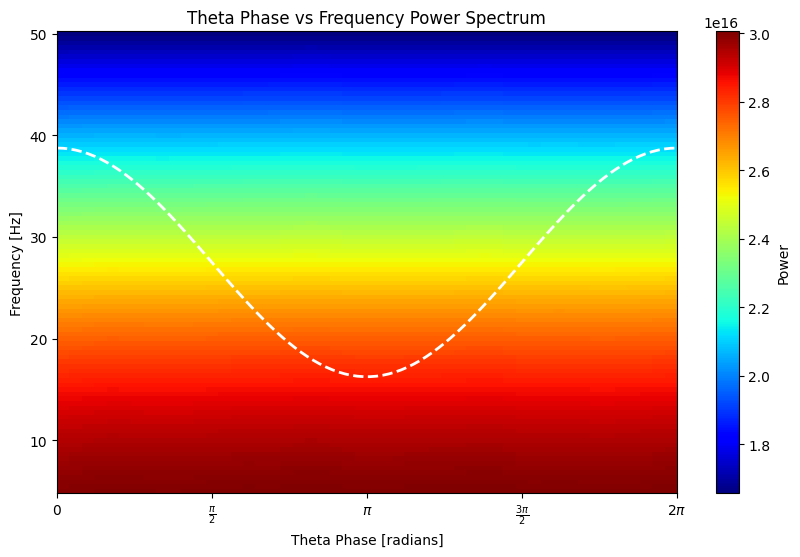

In [31]:
import matplotlib.pyplot as plt
from scipy.signal import morlet

def complex_morlet_wavelet_transform(signal, frequencies, fs):
    """
    Apply the complex Morlet wavelet transform to a signal for a range of frequencies.

    :param signal: The input signal (time series)
    :param frequencies: Array of frequencies for which to compute the transform
    :param fs: Sampling frequency of the input signal
    :return: An array of wavelet coefficients, time x frequencies
    """
    wavelet_coeffs = np.zeros((len(signal), len(frequencies)), dtype=complex)
    
    # Perform wavelet transform for each frequency
    for i, freq in enumerate(frequencies):
        # Calculate the wavelet for given frequency and sampling frequency
        wavelet = morlet(M=len(signal), w=5, s=freq / fs)
        # Convolve signal with the wavelet
        wavelet_coeffs[:, i] = np.convolve(signal, wavelet, mode='same')
    
    return wavelet_coeffs

def plot_wavelet_power_spectrum(wavelet_coeffs, times, frequencies):
    """
    Plot a time-resolved power spectrum from the wavelet coefficients.

    :param wavelet_coeffs: Wavelet coefficients as returned by complex_morlet_wavelet_transform
    :param times: Array of time points corresponding to the signal
    :param frequencies: Array of frequencies used in the wavelet transform
    """
    power_spectrum = np.abs(wavelet_coeffs) ** 2
    
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(times, frequencies, power_spectrum.T, cmap='jet')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Power')
    plt.title('Time-Resolved Power Spectrum')
    plt.tight_layout()
    
    
# Define the frequency range for the analysis
frequencies = np.linspace(5, 50, 100)  # 100 frequencies from 20 to 200 Hz
t_min = 50000
t_max = 100000
lfp_data = obj.lfp_data[0]['data'][t_min:t_max,1]
theta_phase = obj.lfp_data[0]['theta_phase'][t_min:t_max,1]

# Perform the wavelet transform
wavelet_coeffs = complex_morlet_wavelet_transform(lfp_data, frequencies, lfp_sampling_rate)

n_bins = 50  # Number of bins for theta phase
bin_edges = np.linspace(0, 2 * np.pi, n_bins + 1)
power_spectra = np.zeros((len(frequencies), n_bins))

for i in range(n_bins):
    # Find indices for the current theta phase bin
    indices = np.where((theta_phase >= bin_edges[i]) & (theta_phase < bin_edges[i + 1]))[0]

    # Extract the wavelet coefficients for these indices
    selected_coeffs = wavelet_coeffs[indices, :]

    # Calculate the average power spectrum for this phase bin
    power_spectra[:, i] = np.mean(np.abs(selected_coeffs) ** 2, axis=0)
    
# Smooth data across phase bins
from scipy.ndimage import gaussian_filter1d
# Apply this to each frequency bin
sigma = 2  # Standard deviation for Gaussian kernel
smoothed_power_spectra = np.array([gaussian_filter1d(power_spectra[i, :], sigma) for i in range(power_spectra.shape[0])])


# Plotting
theta_bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.figure(figsize=(10, 6))
plt.pcolormesh(theta_bin_centers, frequencies, smoothed_power_spectra, cmap='jet')
plt.xlabel('Theta Phase [radians]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Power')
plt.title('Theta Phase vs Frequency Power Spectrum')

# Adjust the x-axis to show multiples of pi
x_ticks = np.linspace(0, 2 * np.pi, 5)  # 0, pi/2, pi, 3pi/2, 2pi
x_labels = ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
plt.xticks(x_ticks, x_labels)

# Overlay a theta cycle
theta_cycle = np.cos(np.linspace(0, 2 * np.pi, 100))
theta_phase_values = np.linspace(0, 2 * np.pi, 100)
offset = np.median(frequencies)  # Adjust as per your plot
theta_cycle_normalized = theta_cycle * np.ptp(frequencies)/4 + offset
plt.plot(theta_phase_values, theta_cycle_normalized, color='white', linestyle='--', linewidth=2)

plt.show()

# # Plot the power spectrum
# plot_wavelet_power_spectrum(wavelet_coeffs, obj.lfp_data[1]['timestamps'][t_min:t_max], frequencies)

# plt.plot(obj.lfp_data[1]['timestamps'][t_min:t_max], (filtered_lfp[t_min:t_max]/300)+50, c = 'w')
# plt.show()

## Plot mean frequency power spectrogram across theta phase for each session for contact at 0um, -300um, -600um from 20-200Hz

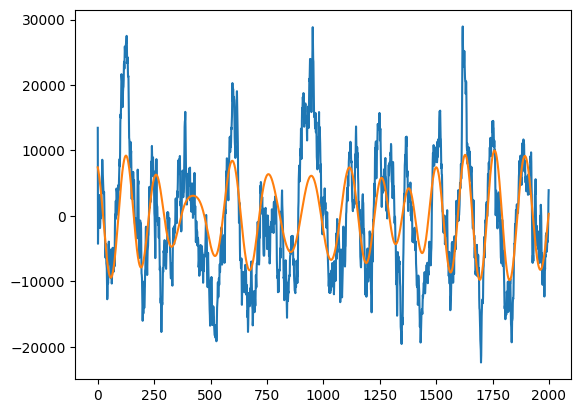

In [5]:
from scipy.signal import hilbert, firwin, filtfilt, argrelmax
import matplotlib.pyplot as plt

# Find peak theta frequencies for each channel and make dict of {channel: theta_freq}
theta_freqs = get_theta_frequencies(obj.lfp_data[0]['data'], lfp_sampling_rate)
theta_freqs = dict(zip(channels_to_load, theta_freqs))

peak_freq = theta_freqs[15]
filt_half_bandwidth = 2
lfp = obj.lfp_data[0]['data'][:,0]

low_freq = peak_freq - filt_half_bandwidth
high_freq = peak_freq + filt_half_bandwidth
filter_taps = firwin(round(lfp_sampling_rate) + 1, [low_freq, high_freq], pass_zero=False, window='blackman', fs=lfp_sampling_rate)
pad_length = min(3 * (len(filter_taps) - 1), len(lfp) - 1)
filtered_lfp = filtfilt(filter_taps, 1, lfp, padlen=pad_length)

# find theta peaks (this is 0)
maxima = argrelmax(filtered_lfp[:2000])[0]

cycles = np.lib.stride_tricks.as_strided(maxima, shape=(maxima.size - 1, 2), strides=(maxima.strides[0], maxima.strides[0]))
cycles

# for cycle in cycles:
#     plt.plot(obj.lfp_data[0]['data'][cycle[0]:cycle[1],0])

plt.plot(obj.lfp_data[0]['data'][:2000,0])
    
# plt.scatter(argrelmax(filtered_lfp[:2000]), [0]*cycles, c = 'r')

plt.plot(filtered_lfp[:2000])


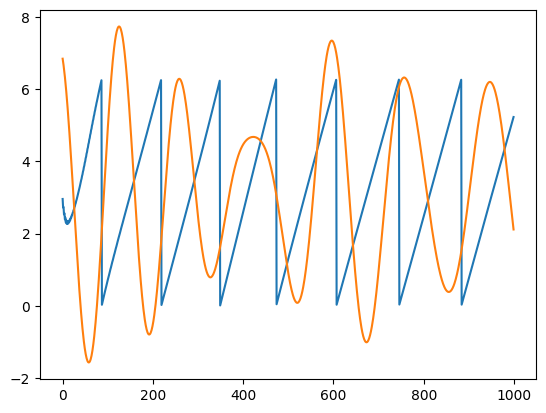

In [11]:
plt.plot(theta_phase[0][:1000])
plt.plot((filtered_lfp[:1000]/2000)+np.pi)

## Plot CSD across theta phase for each open field trial, save result to dataframe

## For each t-maze trial - plot CSD by arm, save result to dataframe

## Mean across all trials for open field